In [1]:
import os
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt

In [2]:
# Load the data
imgs = np.zeros((8,8,200))
a = int(input("a: (0~9)"))
b = int(input("b: (0~9)"))
for i in range(100):
    imgs[:,:,i] = cv.resize(cv.imread("dataset/"+str(100*a+i+1)+".png",cv.IMREAD_GRAYSCALE), (8,8))
    imgs[:,:,i+100] = cv.resize(cv.imread("dataset/"+str(100*b+i+1)+".png",cv.IMREAD_GRAYSCALE), (8,8))

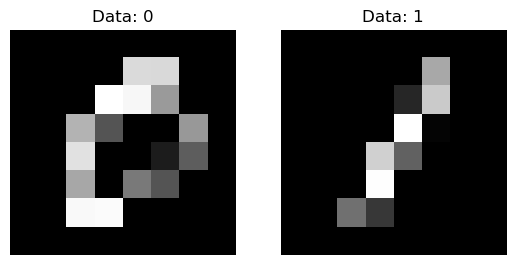

In [3]:
# Show input data
fig = plt.figure()
plt.subplot(121)
plt.axis('off')
plt.title("Data: " + str(a))
plt.imshow(imgs[:,:,0],"gray")
plt.subplot(122)
plt.axis('off')
plt.title("Data: " + str(b))
plt.imshow(imgs[:,:,100],"gray")

In [89]:
# Create filter1 & filter2
filter1 = np.array([[-1, -1, 1], [-1, 0, 1], [-1, 1, 1]])
#filter2 = np.array([[0, -1, 0], [-1, 4, -1], [0, -1, 0]])
filter2 = np.ones((3,3))/9

In [90]:
# convolve2D
def convolve2D(image, kernel, padding=0, strides=1):
    kernel = np.flipud(np.fliplr(kernel))
    xKernShape = kernel.shape[0] 
    yKernShape = kernel.shape[1] 
    xImgShape = image.shape[0] 
    yImgShape = image.shape[1]

    xOutput = int(((xImgShape - xKernShape + 2 * padding) / strides) + 1)
    yOutput = int(((yImgShape - yKernShape + 2 * padding) / strides) + 1)
    output = np.zeros((xOutput, yOutput))
    
    # Padding
    if padding != 0:
        imagePadded = np.zeros((image.shape[0] + padding*2, image.shape[1] + padding*2))
        imagePadded[int(padding):int(-1 * padding), int(padding):int(-1 * padding)] = image
        # print(imagePadded)
    else:
        imagePadded = image

    for y in range(image.shape[1]):
        # Exit Convolution
        if y > image.shape[1] - yKernShape:
            break
        # Only Convolve if y has gone down by the specified Strides
        if y % strides == 0:
            for x in range(image.shape[0]):
                # Go to next row once kernel is out of bounds
                if x > image.shape[0] - xKernShape:
                    break
                try:
                    # Only Convolve if x has moved by the specified Strides
                    if x % strides == 0:
                        output[x, y] = (kernel * imagePadded[x: x + xKernShape, y: y + yKernShape]).sum()
                except:
                    break

    return output

In [91]:
# max pooling
def max_pool(img):
    ds_img = np.zeros((img.shape[0]//2,img.shape[1]//2))
    for i in range(ds_img.shape[0]):
        for j in range(ds_img.shape[1]):
            ds_img[i,j]=img[2*i+0:2*i+2,2*j+0:2*j+2].max()
    return ds_img

In [92]:
output = np.zeros((8,8,2,200))
output2 = np.zeros((4,4,2,200))
output3 = np.zeros((2,2,2,200))
output4 = np.zeros((9,200))

for i in range(200):
    output[:,:,0,i] = convolve2D(imgs[:,:,i],filter1, 1, 1)
    output[:,:,1,i] = convolve2D(imgs[:,:,i],filter2, 1, 1)

    output2[:,:,0,i] = max_pool(output[:,:,0,i])
    output2[:,:,1,i] = max_pool(output[:,:,1,i])

    output2[:,:,0,i] = convolve2D(output2[:,:,0,i],filter1, 1, 1)
    output2[:,:,1,i] = convolve2D(output2[:,:,1,i],filter2, 1, 1)

    output3[:,:,0,i] = max_pool(output2[:,:,0,i])
    output3[:,:,1,i] = max_pool(output2[:,:,1,i])

    output4[0:8,i] = output3[:,:,:,i].flatten()
    output4[8,i] = 1
    
# Normalizing
for i in range(9):
    if output4[i,:].max() == output4[i,:].min():
        output4[i,:] = 1
    else:
        output4[i,:] = output4[i,:] / np.linalg.norm(output4[i,:])

In [93]:
# Create label
X = output4.T
Y = np.concatenate((np.zeros((100,1)),np.ones((100,1))))

In [94]:
# Linear regression
A = X.T.dot(np.linalg.inv(X.dot(X.T))).dot(Y)
# A = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(Y)

In [95]:
Yp = X.dot(A)